In [1]:
# NOT WORKING: need to fix forward (unconditional generation)

In [2]:
import os
import sys
sparse_multiview = f'{os.getcwd()}/../sparse_multiview'
sys.path.append(sparse_multiview)
from multiview import *
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
args = OmegaConf.load(f'{sparse_multiview}/configs/views5.yaml')

2023-02-12 21:46:29.975915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 21:46:31.042296: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-12 21:46:31.042372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-12 21:46:31.042379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Keeping only azim and elev in [-20,20]


In [3]:
#model = MultiViewDiffusionModel(args).cuda()
#model.eval()

['dog']
tensor([[ 33.1948, -22.8163]])


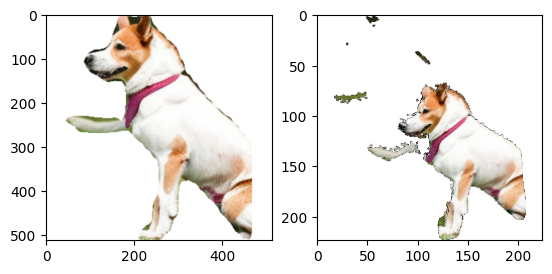

In [4]:
dataset = MultiViewDataset(args)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    #pin_memory=True
)
batch = next(iter(dataloader))
print(batch['class'])
target = batch['target'].squeeze().permute((1, 2, 0))
source = batch['source'].squeeze().permute((1, 2, 0))
print(batch['pose'])
fig, axs = plt.subplots(1, 2)
axs[0].imshow((target+1)/2)
axs[1].imshow((source+1)/2)
plt.show()

In [5]:
#batch = {k:v.cuda() if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
#images = model.forward(batch)
#images

In [6]:
#images

In [7]:
images, attention_maps = model.forward_with_crossattention(batch)
attention_maps = attention_maps.detach().cpu()
orig_image = images
orig_image

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_96897/1423579898.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_96897/1423579898.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'model' is not defined

In [ ]:
fig, axs = plt.subplots(attention_maps.shape[-1]//5, 5, figsize=(20, 20))
for i in range(attention_maps.shape[-1]):
    axs[i//5, i%5].imshow(attention_maps[:,:,i])
    axs[i//5, i%5].set_axis_off()
plt.show()

In [ ]:
# Inspired by 
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/notebooks/explain.ipynb
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/utils/vis_utils.py 
# https://github.com/AttendAndExcite/Attend-and-Excite/blob/main/utils/ptp_utils.py

import ptp_utils
from vis_utils import show_image_relevance
# show spatial attention for indices of tokens to strengthen
n_tokens = attention_maps.shape[2]
res = 16

mae = model.multiview_encoder.model
m = n_tokens // dataset.num_views_per_inst

context = batch['views']
context = context.view(-1, *context.shape[2:])
context_tokens = mae.patchify(context.cuda()).reshape(-1, 768).cpu().numpy()
non_white = np.abs(context_tokens-1).mean(axis=1)
context_tokens = np.array([context_tokens[i] for i in range(len(context_tokens)) if non_white[i] >= 1e-2])

for view in range(dataset.num_views_per_inst):
    images = []
    for i in range(view*m, view*m+m):
        image = attention_maps[:, :, i]
        image = show_image_relevance(image, orig_image)
        image = image.astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((res ** 2, res ** 2)))
        images.append(image)
    ptp_utils.view_images(np.stack(images[1:11], axis=0))
    plt.show()
    
    imgs = context_tokens.reshape(-1, 3, 16, 16).transpose((0,2,3,1))
    #imgs = context_tokens[:10].reshape(-1, 16, 16, 3)
    #print(imgs[0])
    fig, axs = plt.subplots(1, len(imgs))
    for i in range(len(imgs)):
        axs[i].imshow(imgs[i])
        axs[i].set_axis_off()
    plt.show()